---
title: "LD filtering of UKBB data"
author: "Saikat Banerjee"
format:
  html: default
date: "2023-11-27"
file-modified: "2023-11-27"
abstract: "A simple position based filtering for SNPs in the UKBB data. Position is used as a proxy for true LD."

---

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sc_stats
import collections
import pickle

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

In [2]:
phenotype_metafile = "/gpfs/commons/home/sbanerjee/work/npd/UKBB/npd_phenotypes.tsv"
variants_metafile = "/gpfs/commons/home/sbanerjee/work/npd/UKBB/metadata/significant_variants.tsv"
data_dir = "/gpfs/commons/home/sbanerjee/npddata/ukbb.imputed_v3.neale/3_all_assoc"

In [3]:
phenotype_df = pd.read_csv(phenotype_metafile, sep = '\t')
phenotype_df

,phenotype,description,variable_type,source,n_non_missing,n_missing,n_controls,n_cases,PHESANT_transformation,notes
0,1160,Sleep duration,ordinal,phesant,359020,2174,NaN,NaN,1160_0|| INTEGER || reassignments: -1=NA|-3=NA...,"ACE touchscreen question ""About how many hours..."
1,1200,Sleeplessness / insomnia,ordinal,phesant,360738,456,NaN,NaN,1200_0|| CAT-SINGLE || Inc(>=10): 3(102157) ||...,"ACE touchscreen question ""Do you have trouble ..."
2,1220,Daytime dozing / sleeping (narcolepsy),ordinal,phesant,359752,1442,NaN,NaN,1220_0|| CAT-SINGLE || reassignments: 3=2 || I...,"ACE touchscreen question ""How likely are you t..."
3,1920,Mood swings,binary,phesant,352604,8590,193622.0,158982.0,1920_0|| CAT-SINGLE || Inc(>=10): 0(193622) ||...,"ACE touchscreen question ""Does your mood often..."
4,1970,Nervous feelings,binary,phesant,351829,9365,268709.0,83120.0,1970_0|| CAT-SINGLE || Inc(>=10): 0(268709) ||...,"ACE touchscreen question ""Would you call yours..."
...,...,...,...,...,...,...,...,...,...,...
312,T79,Diagnoses - main ICD10: T79 Certain early comp...,binary,icd10,361194,0,360989.0,205.0,NaN,NaN
313,TRAUMBRAIN_NONCONCUS,"severe traumatic brain injury, does not includ...",binary,finngen,361194,0,360631.0,563.0,NaN,NaN
314,VI_NERVOUS,Diseases of the nervous system,binary,finngen,361194,0,339871.0,21323.0,NaN,NaN
315,V_MENTAL_BEHAV,Mental and behavioural disorders,binary,finngen,361194,0,356892.0,4302.0,NaN,NaN


In [4]:
phenotype_ids = phenotype_df['phenotype'].to_list()
assoc_file = {}
for s in phenotype_ids:
    assoc_file[s] = f"{data_dir}/{s}.tsv"

In [7]:
assoc_df = pd.read_pickle("../data/ukbb_assoc.pkl")
assoc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13311781 entries, 0 to 41992
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   variant         object 
 1   low_confidence  bool   
 2   beta            float64
 3   se              float64
 4   tstat           float64
 5   pval            float64
 6   phenotype_id    object 
dtypes: bool(1), float64(4), object(2)
memory usage: 723.6+ MB


In [8]:
print (f"Number of unique SNPs: {len(assoc_df['variant'].unique())}")
print (f"Number of unique studies: {len(assoc_df['phenotype_id'].unique())}")

Number of unique SNPs: 41993
Number of unique studies: 317


In [9]:
variant_colnames = ['variant', 'chr', 'pos', 'ref', 'alt', 'rsid', 'varid', 
                    'consequence', 'consequence_category', 'info', 'call_rate',
                    'AC', 'AF', 'minor_allele', 'minor_AF', 'p_hwe', 
                    'n_called', 'n_not_called', 'n_hom_ref', 'n_het', 'n_hom_var', 'n_non_ref',
                    'r_heterozygosity', 'r_het_hom_var', 'r_expected_het_frequency']
variant_df = pd.read_csv(variants_metafile, sep = '\t', names = variant_colnames)

def count_nucleotides(row):
    return len(row['ref']) + len(row['alt'])

variant_df['ntcount'] = variant_df.apply(count_nucleotides, axis = 1)
variant_df_filtered = variant_df[(variant_df['ntcount'] == 2) 
                               & (variant_df['minor_AF'] >= 0.05)
                               & (variant_df['info'] >= 0.8)].drop(columns = ['ntcount'])

In [66]:
variant_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37395 entries, 9 to 41991
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   variant                   37395 non-null  object 
 1   chr                       37395 non-null  int64  
 2   pos                       37395 non-null  int64  
 3   ref                       37395 non-null  object 
 4   alt                       37395 non-null  object 
 5   rsid                      37395 non-null  object 
 6   varid                     37395 non-null  object 
 7   consequence               37395 non-null  object 
 8   consequence_category      37395 non-null  object 
 9   info                      37395 non-null  float64
 10  call_rate                 37395 non-null  float64
 11  AC                        37395 non-null  int64  
 12  AF                        37395 non-null  float64
 13  minor_allele              37395 non-null  object 
 14  minor_AF   

In [67]:
def ldclump_snppos(xarr, pos_cutoff=100000):
    xclump = list()
    xsorted = np.sort(xarr)
    xlast = xsorted[0]
    xclump.append(xlast)
    for x in xsorted[1:]:
        if (x - xlast > pos_cutoff):
            xclump.append(x)
            xlast = x
    return np.array(xclump)

In [76]:
ldfilter_dict = []
for chrm in range(1,23):
    chr_snppos = variant_df_filtered[variant_df_filtered['chr'] == chrm]['pos'].values
    chr_snppos_filtered = ldclump_snppos(chr_snppos, pos_cutoff = 10000)
    ldfilter_dict += [{'chr':chrm, 'pos':x} for x in chr_snppos_filtered]

In [77]:
len(ldfilter_dict)

3386

In [84]:
df_ldfilter = pd.DataFrame.from_dict(ldfilter_dict)
variant_df_ldfiltered = df_ldfilter.merge(variant_df_filtered, on=['chr', 'pos'], how='inner')

In [85]:
variant_df_ldfiltered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   chr                       3387 non-null   int64  
 1   pos                       3387 non-null   int64  
 2   variant                   3387 non-null   object 
 3   ref                       3387 non-null   object 
 4   alt                       3387 non-null   object 
 5   rsid                      3387 non-null   object 
 6   varid                     3387 non-null   object 
 7   consequence               3387 non-null   object 
 8   consequence_category      3387 non-null   object 
 9   info                      3387 non-null   float64
 10  call_rate                 3387 non-null   float64
 11  AC                        3387 non-null   int64  
 12  AF                        3387 non-null   float64
 13  minor_allele              3387 non-null   object 
 14  minor_AF

In [86]:
assoc_df_fvar = variant_df_ldfiltered[['variant', 'rsid']].merge(assoc_df, on = ['variant'], how = 'inner')

In [87]:
print (f"Number of unique SNPs: {len(assoc_df_fvar['variant'].unique())}")
print (f"Number of unique studies: {len(assoc_df_fvar['phenotype_id'].unique())}")

Number of unique SNPs: 3387
Number of unique studies: 317


In [88]:
zscore_df = assoc_df_fvar[['variant', 'phenotype_id', 'tstat']].pivot(index = 'variant', columns = 'phenotype_id', values = 'tstat').rename_axis(None, axis = 0).rename_axis(None, axis = 1)
beta_df   = assoc_df_fvar[['variant', 'phenotype_id', 'beta']].pivot(index = 'variant', columns = 'phenotype_id', values = 'beta').rename_axis(None, axis = 0).rename_axis(None, axis = 1)
se_df     = assoc_df_fvar[['variant', 'phenotype_id', 'se']].pivot(index = 'variant', columns = 'phenotype_id', values = 'se').rename_axis(None, axis = 0).rename_axis(None, axis = 1)

In [89]:
zscore_df

,1160,1200,1220,1920,1970,1980,20002_1123,20002_1240,20002_1243,20002_1246,...,R53,R56,R90,SFN,SLEEP,T79,TRAUMBRAIN_NONCONCUS,VI_NERVOUS,V_MENTAL_BEHAV,Z43
10:100010186:A:G,-0.501456,0.468240,-1.401350,-2.319730,-4.101760,-2.469050,1.373340,0.807527,-1.483770,-0.983242,...,-1.047450,-0.541606,-1.559310,0.746273,0.644985,-0.028021,-0.159701,3.711700,-1.380550,-0.903030
10:100020572:T:G,0.687418,-0.769290,0.041449,-2.215650,-1.051370,-0.254845,0.022909,-0.961978,-0.344766,-1.693950,...,-0.750566,0.989090,0.516234,-0.152721,-0.266356,1.091550,-0.054509,3.134090,-1.631720,-0.641998
10:100602545:C:G,0.197858,0.137792,0.064242,-1.027020,-0.967476,-0.528904,1.598920,-0.491628,-0.103273,-0.099966,...,1.198700,0.925530,-0.146606,1.605810,0.764948,2.064470,1.832110,1.723660,-0.391214,0.789003
10:100612750:G:C,0.243301,0.144469,0.043636,-0.979825,-0.982524,-0.524519,1.652070,-0.498177,0.032667,-0.131171,...,1.208040,1.012120,-0.168484,1.617130,0.776149,2.232480,1.825990,1.762370,-0.351120,0.801818
10:100627302:G:C,0.303313,0.288102,-0.243662,-1.241620,-0.917032,-0.624787,1.616470,-0.359382,0.038058,-0.138088,...,0.959963,1.038140,-0.187544,1.637230,0.858652,1.866400,1.898110,1.759880,-0.374304,0.609954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9:98225056:G:T,-0.609864,0.191835,2.357520,3.899610,3.187290,5.256400,0.402311,1.592520,-0.382107,1.365880,...,1.017950,1.900860,2.127600,0.056486,0.692330,-0.307143,-0.591845,0.056605,-0.247403,-1.640570
9:98235310:T:C,-0.731896,-0.239943,1.869780,3.750520,3.260280,5.254040,-0.255022,0.183105,0.344827,1.237990,...,0.913732,1.789060,1.465640,0.407725,0.614795,-0.168933,-0.381017,0.452154,0.714727,-1.272540
9:98247204:C:T,-0.627788,0.057694,2.106230,4.309430,3.180430,4.965740,0.358445,0.787971,-0.052250,1.509800,...,0.796777,1.726200,1.235950,-0.052887,1.313870,-0.505464,-0.119510,-0.124091,1.065030,-1.160720
9:98262178:G:A,-0.619834,-0.240170,2.556200,4.230840,3.632350,4.855730,0.002387,0.601861,0.154543,1.272620,...,0.684594,1.329930,1.257680,0.055839,0.996216,-0.217356,-0.178359,-0.336342,1.148090,-1.059110


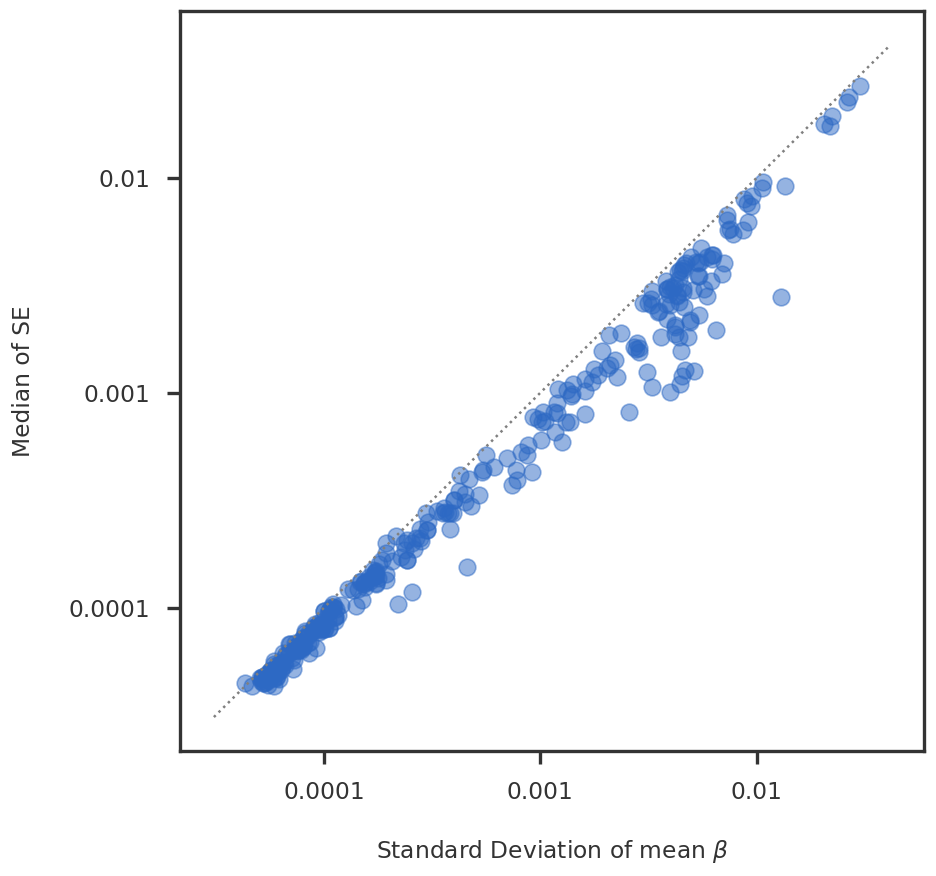

In [90]:
#| label: fig-se-vs-beta-std
#| fig-cap: "Calibration of SE against std of beta"

mean_se  = se_df.median(axis = 0, skipna = True)
mean_se  = pd.DataFrame(mean_se).set_axis(["mean_se"], axis = 1)
beta_std = beta_df.std(axis = 0, skipna = True)
beta_std = pd.DataFrame(beta_std).set_axis(["beta_std"], axis = 1)
error_df = pd.concat([mean_se, beta_std], axis = 1)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.log10(error_df['beta_std']), np.log10(error_df['mean_se']), alpha = 0.5, s = 100)
mpl_utils.set_xticks(ax1, scale = 'log10', spacing = 'log10')
mpl_utils.set_yticks(ax1, scale = 'log10', spacing = 'log10')
mpl_utils.plot_diag(ax1)

keep_columns = error_df.query("mean_se <= 0.2").index
for pid in error_df.index.to_list():
    if pid not in keep_columns:
        pid_text = f"{pid} / {phenotype_dict[pid]}"
        xval = np.log10(error_df.loc[pid]['beta_std'])
        yval = np.log10(error_df.loc[pid]['mean_se'])
        ax1.annotate(pid_text, (xval, yval))

ax1.set_xlabel(r"Standard Deviation of mean $\beta$")
ax1.set_ylabel(r"Median of SE")
plt.show()

In [92]:
zscore_df.to_pickle("../data/ukbb_zscore_df2.pkl")
beta_df.to_pickle("../data/ukbb_beta_df2.pkl")
se_df.to_pickle("../data/ukbb_se_df2.pkl")